## Topic 5. Neural Networks
## Competitive Learning, Self-organizing maps


In [2]:
# We start by importing the python libraries required to solve the problems

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

# From sklearn we will use the implementations of the Multi-layer perceptron, and the Boltzmann Machines
from sklearn import cluster
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM
#from sklearn.datasets.mldata import fetch_mldata

# We will also use different metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn import metrics
import sompy3


# We will also discuss about on the neupy implementation of RBM and the Somoclu 
# implementation of Self-Organizing-Maps
from neupy import algorithms
import somoclu


from IPython.display import display
from IPython.display import Image

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Competitive Learning

To understand how Neural Vector Quantization works, we start by illustrating how Image Quantization can be implemented using a clustering algorithm like kmeans. For this introduction we use a modified version of the example presented here: http://scikit-learn.org/stable/auto_examples/cluster/plot_face_compress.html


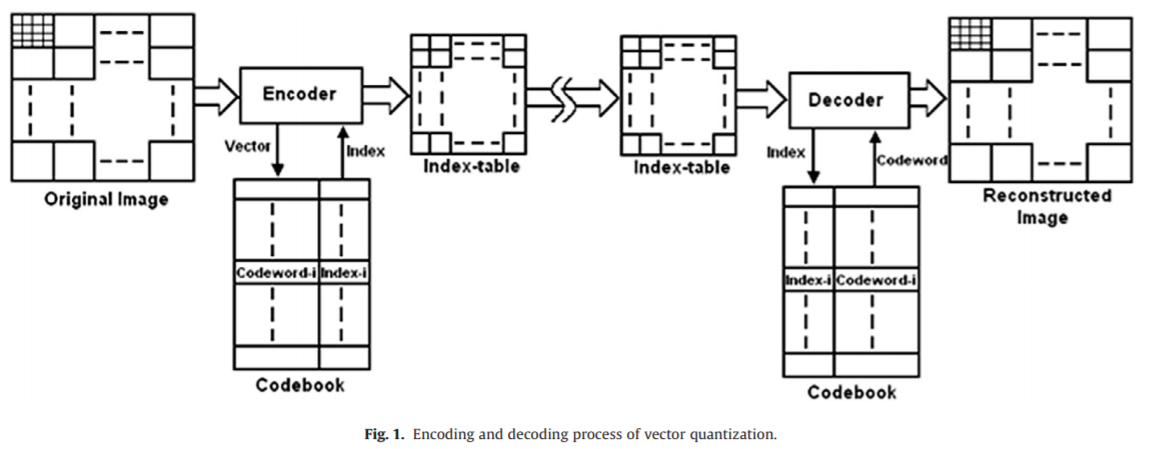

In [4]:
i = Image(filename='Image_Quantization.png')
i

The figure above shows a schematic representation of Image Quantization. The goal is to obtain a compressed representation of an image. To do this, a Codebook is created where a number of Codewords or Codevectors are defined together with an index. The Codebook works similarly to a hash table. For each pixel in the image, we look for the corresponding Codeword in the Codebook and use the index of the Codeword to represent the pixel. We assume that the number of indices is much smaller than the possible values of a pixel. For example, if we need 8 bits to represent the 256 values of a pixel, we only need 3 bits to represent 8 indices.


The storing cost of the Quantization Mechanism is the number of pixels multiplied by the bits needed to represent an index plus the storing cost of the Codebook.


To decode an image, we simply get the set of indices and recover the corresponding Codewords in the Codebook. Obviously, the selection of good Codewords determines the quality of the Vector Quantization algorithm. 

In the following code, the kmeans algorithm is used to find the Codewords of an image.

We start by reading an image, the "ascent" image. 

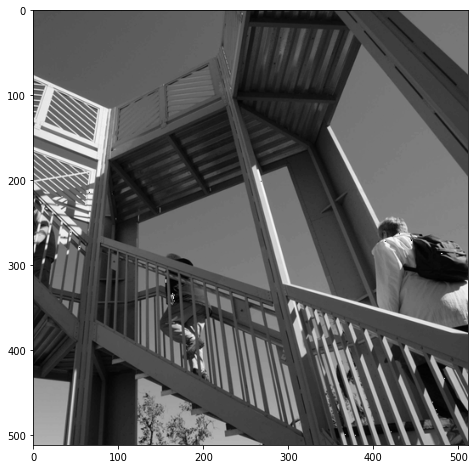

In [6]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# Modified by Roberto Santana
# License: BSD 3 clause

try:  # SciPy >= 0.16 has ascent in misc
    from scipy.misc import ascent  
    ascent = sp.misc.ascent()
except ImportError:
    ascent = sp.ascent()

ascent_shape = ascent.shape

vmin = ascent.min()
vmax = ascent.max()

# original ascent
plt.figure(1, figsize=(8, 8))
plt.imshow(ascent, cmap=plt.cm.gray, vmin=vmin, vmax=256)

## Encoding phase

Using kmeans we cluster all pixels of the image in five clusters.

In [7]:
n_clusters = 5
np.random.seed(0)

X = ascent.reshape((-1, 1))  # We need an (n_sample, n_feature) array
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(X)

KMeans(n_clusters=5, n_init=4)

The *values* variable contains the centroids of the five clusters (the five Codewords) and labels have for each pixel, its corresponding index. We print all Codevectors and some of the pixel indices.

In [8]:
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
print(values)
print(labels[:20000:1000])

[127.33193545  91.34660051  28.48289798 199.84608461  62.51254379]
[1 0 0 0 4 4 4 2 2 2 2 2 1 1 1 1 1 1 1 1]


## Decoding phase

Using the Codebook (values) and the labels, we reconstruct the image.

In [9]:
# create an array from labels and values
ascent_compressed = np.choose(labels, values)
ascent_compressed.shape = ascent.shape

Finally, we print the original image and the one that was quantized. Notice that although there is some deterioration of the image quality, it can be recognized and many details are not lost.

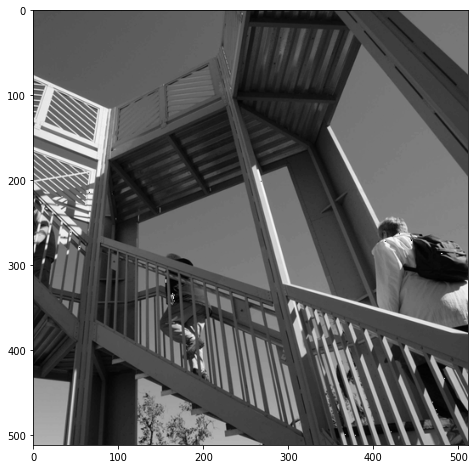

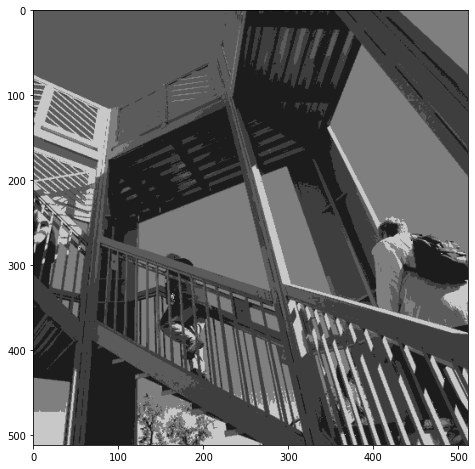

In [10]:
vmin = ascent.min()
vmax = ascent.max()

# original ascent
plt.figure(1, figsize=(8, 8))
plt.imshow(ascent, cmap=plt.cm.gray, vmin=vmin, vmax=256)

# compressed ascent
plt.figure(2, figsize=(8, 8))
plt.imshow(ascent_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)


plt.show()

## Neural quantization

Now, we will use a Vector Quantization approach to learn a quantization of the image. Vector quantization is a Competitive Learning approach where k neurons compete for representing the input data. In the network topology, each of the k neurons is connected to all the inputs by a weight vector. 

Every time an input is presented to the network, all neurons compute their distance to the input, and the neuron that is the closest neuron (Best Matching Unit) is selected. This is called the winner, and in this approach the "winner-takes-all", that means that this neuron and only it will update its weight getting closer to the input. 


The following code implements the Vector Quantization approach for finding Codewords. In this application, the neurons will represent the Codebook. The index of each neuron is the index of the Codeword, and the vector of weights is the Codeword. 


Read the comments to the code and execute it.

In [11]:
from scipy.spatial import distance


# The Codebook contains n_codevectors, each of n_features
# All Codewords are randomly generated
def Init_Code_Vectors(n_codevectors,n_features):
    CodeBook = np.random.rand(n_codevectors,n_features)
    return CodeBook


# The Best Matching Unit (BMU) is the Codeword that is closest
# to the instance according to the Euclidean distance
# The algorithm computes the distances for all Codevectors
# and outputs the index, in the Codebook of the BMU
def Find_Best_Matching_Unit(instance,CodeBook):
    n_codevectors = CodeBook.shape[0]
    dist = np.zeros((n_codevectors))
    for i in range(n_codevectors):
        dist[i] = distance.euclidean(instance,CodeBook[i,:])
    BMU = np.argmin(dist)
    return BMU



# The weights of the BMU are updated. 
# This is done by moving the BMU in the direction of of the instance
# Notice the similarity with the learning rule used to learn the Perceptron
# as studied in previous lessons
def Update_BMU(BMU_Weights,instance,learning_rate):
    delta_W = (instance - BMU_Weights)
    new_BMU_Weights = BMU_Weights + learning_rate*delta_W
    return new_BMU_Weights


# This is the main implementation of the Vector Quantization algorithm
# It receives a set of instances (training data), the number of CodeVectors
# that we want in the Codebook (the number of neurons). 
# The number of iterations of the algorithm (in each iterations all the instances
# are given to the network as input) and the learning_rate
def Vector_Quantization(instances,n_codevectors,n_epochs,learning_rate):
    n_instances, n_features = instances.shape
    # The Codebook is randomly initialized
    CodeBook = Init_Code_Vectors(n_codevectors,n_features)
    
    # We plot the location of the neurons (defined by their weights)
    Plot_Instances_and_Prototypes(instances,CodeBook)
    Index = np.zeros((n_instances), dtype=np.int)
    
    # In each iteration, for a given instance, first the BMU is found.
    # That way we obtain the index for that particular instance
    # Then the weight of the BMU is updated
    # At each step we plot the current location of the neurons
    for i in range(n_epochs):
        for j in range(n_instances):  
            BMU_index =  Find_Best_Matching_Unit(instances[j,:],CodeBook)  
            Index[j] = BMU_index
            CodeBook[BMU_index,:]  = Update_BMU(CodeBook[BMU_index,:],instances[j,:],learning_rate)
             
        Plot_Instances_and_Prototypes(instances,CodeBook)
       
    return CodeBook, Index

# Plot the instances as blue squares and the neurons as red 'o'
def Plot_Instances_and_Prototypes(inst,prot):
    #fig = plt.figure()
    if inst.shape[1]>1:
        plt.plot(inst[:,0],inst[:,1],'bs', lw=4)
        plt.plot(prot[:,0],prot[:,1],'ro', lw=4)
    else:
        sns.distplot(inst)
        plt.plot(prot[:,0], [0]*prot.shape[0],'ro', lw=4)
    plt.show()



To test our algorithm, we create a set of 20 2-dimensional vectors located in the corners of a square.
Then the Vector Quantization algorithm is invoked to find the Codevector (centers of the clusters) of these data.
Execute the following cell and observe the figures that are produced. 

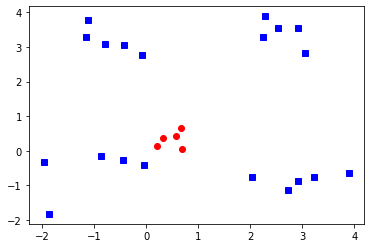

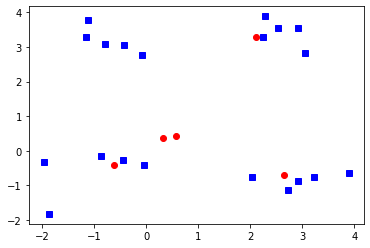

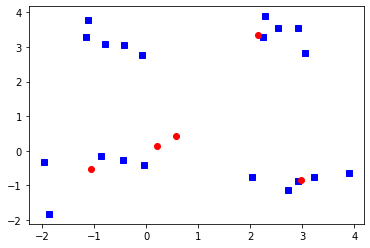

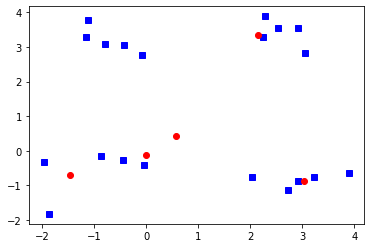

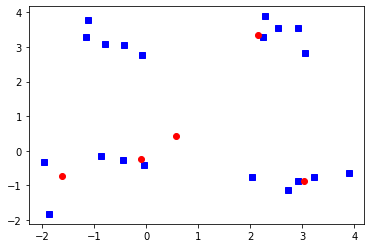

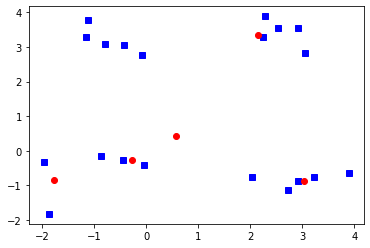

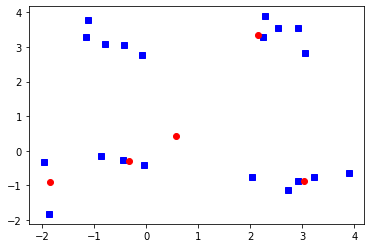

[[ 3.03562943 -0.87132602]
 [ 2.15469059  3.35895688]
 [-1.84335305 -0.89890401]
 [-0.32562377 -0.29144323]
 [ 0.57019677  0.43860151]] [1 1 1 1 1 3 2 2 3 3 1 1 1 1 1 0 0 0 0 0]


In [12]:
n_prototypes = 5
n_features = 2
n_epochs = 6
learning_rate = 0.3

npoints = 5
left_up =   [-2, 2]+ 2*np.random.rand(npoints,2)
left_down = [-2,-2]+ 2*np.random.rand(npoints,2)
right_up =   [2, 2]+ 2*np.random.rand(npoints,2)
right_down = [2,-2]+ 2*np.random.rand(npoints,2)

instances = np.concatenate([left_up,left_down,right_up,right_down])

CodeBook, Index = Vector_Quantization(instances,n_prototypes,n_epochs,learning_rate)
print(CodeBook,Index)




## Exercise 1

- Use function Vector_Quantization to find the CodeBook of image ascent that we have used before.
- Show the image reconstruction obtained with the Neural CodeBook.


Suggestions:
- The only modification required to the program Vector_Quantization is to COMMENT the calls to the  Plot_Instances_and_Prototypes() function.  The exercise consists in finding the right input parameters for this function.
-  Select a small number of epochs (No more than 10)


/home/juletx/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


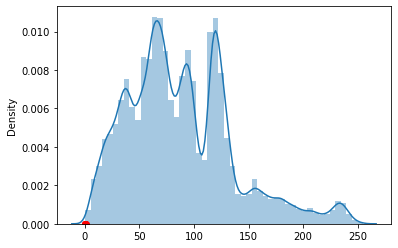

/home/juletx/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


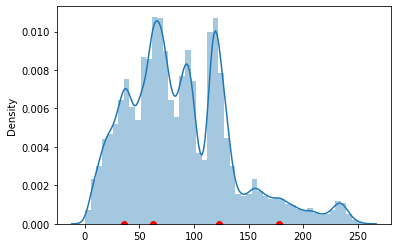

/home/juletx/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


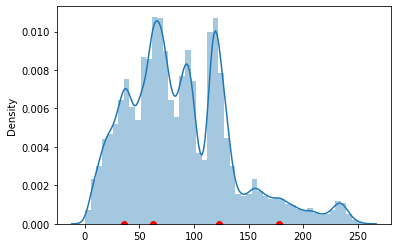

In [13]:
CodeBook, Index = Vector_Quantization(X, 4, 2, 0.01)

[[177.8981473 ]
 [ 35.41109958]
 [123.1431005 ]
 [ 62.86130903]] [3 3 3 ... 3 3 3]


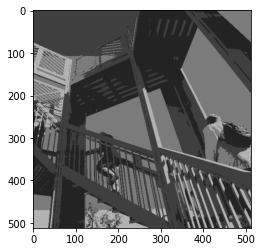

In [14]:
print(CodeBook, Index)
plt.imshow(CodeBook[Index].reshape((ascent_shape)), cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

## Self-organizing maps

Self-organizing maps are another model that belong in the competitive learning framework. Structurally, SOMs have one main difference when compared to Vector Quantization, as in this case, the CodeVectors (called neurons in this layout) are placed in a grid in which the concept of neighborhood is an important feature. Unlike the Vector Quantization concept we just saw, SOMs do not follow *the winner takes it all* approach, the neighbors of the *winners* are also have their weights updated to get closer to the new examples. This way, we can achieve a richer representation. 

Take a look at the following GIF:

https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif



The following example is a modification of that available in https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11

We firstly create a small toy dataset with four clear clusters of points

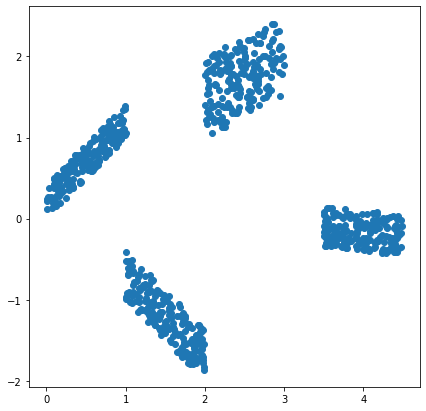

In [18]:
dlen = 200

# C1, C2, C3, and C4 contain points that when interpreted as coordinates in a 2-D grid
# correspond with very different areas in the

c1 = np.random.rand(dlen,2)
c1[:, 1] = c1[:, 0] + .42*np.random.rand(dlen)

c2 = np.random.rand(dlen,2)+1
c2[:, 1] = -c2[:, 0] + .62*np.random.rand(dlen)

c3 = np.random.rand(dlen,2)+2
c3[:, 1] = 0.5*c3[:, 0] + np.random.rand(dlen)

c4 = np.random.rand(dlen,2)+3.5
c4[:, 1] = -0.1*c4[:, 0] + 0.5*np.random.rand(dlen)


data = np.concatenate((c1, c2, c3, c4))  # We put all four clusters of points together

fig = plt.figure()
plt.plot(data[:,0], data[:,1],'o')
fig.set_size_inches(7,7)

Next, we train a SOM for that data

In [19]:
mapsize = [20, 20]  # The number of neurons: 20*20
som = sompy3.SOMFactory.build(data, mapsize, normalization=None)
som.train(n_job=1, verbose='info') 

INFO:root: Training...
INFO:root: pca_linear_initialization took: 0.032000 seconds
INFO:root: Rough training...
INFO:root: radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 15

INFO:root: epoch: 1 ---> elapsed time:  0.128000, quantization error: 0.249562

INFO:root: epoch: 2 ---> elapsed time:  0.110000, quantization error: 0.131411

INFO:root: epoch: 3 ---> elapsed time:  0.115000, quantization error: 0.095915

INFO:root: epoch: 4 ---> elapsed time:  0.125000, quantization error: 0.095205

INFO:root: epoch: 5 ---> elapsed time:  0.135000, quantization error: 0.083731

INFO:root: epoch: 6 ---> elapsed time:  0.115000, quantization error: 0.080771

INFO:root: epoch: 7 ---> elapsed time:  0.109000, quantization error: 0.074749

INFO:root: epoch: 8 ---> elapsed time:  0.116000, quantization error: 0.069758

INFO:root: epoch: 9 ---> elapsed time:  0.119000, quantization error: 0.065014

INFO:root: epoch: 10 ---> elapsed time:  0.117000, quantization error: 0.059676

INFO:root: epoc

In the following cell, we can see what each of the component has learned. Remember that we have trained 20*20 neurons.

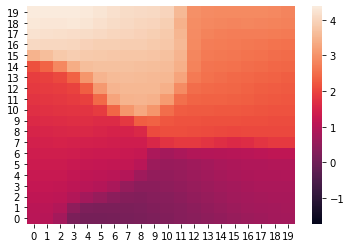

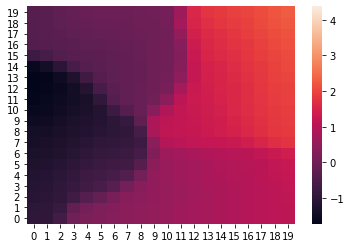

In [20]:
c1, c2 = som.codebook.matrix[:, 0].reshape(mapsize), som.codebook.matrix[:, 1].reshape(mapsize)  # We select the two components (dimensions) in the map, and reshape them
# Two heatmaps, one per component
sns.heatmap(c1, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 20)
plt.show()
sns.heatmap(c2, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 20)
plt.show()

## Exercise 2

Note that the colors represented in the heatmaps vary a little bit. This means that the range of values taken by the two components are different. Why is that?

In the following cell, we visualize the placement of the neurons of the SOM on top of the points of the data

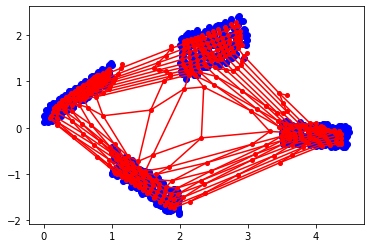

In [21]:
plt.plot(data[:,0], data[:,1],'o', c="b")
plt.plot(som.codebook.matrix[:, 0], som.codebook.matrix[:, 1], "o", c="r", markersize=4)
for i in range(c1.shape[0]-1):
    for j in range(c2.shape[1]-1):
        plt.plot(c1[i, j:j+2], c2[i, j:j+2], c="r")
        plt.plot(c1[i:i+2, j], c2[i:i+2, j], c="r")

## Exercise 3

As you can see, the neurons in the *extreme* placements of the grid gravitated towards the areas in which the points could be found in the original data. However, some points remained in the center of the image. Why is that?

Another thing we can do with the representation in the new dimension is to cluster the points in the data according to closeness in the SOM space. We start by performing clustering on the neurons of the SOM.

In [22]:
cl = som.cluster(n_clusters=4)

This information can also be visualized

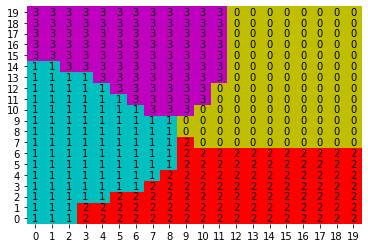

In [23]:
cmap = ["y", "c", "r", "m"]
cluster_space = som.cluster_labels.reshape(mapsize)
sns.heatmap(cluster_space, annot=True, cmap=cmap, annot_kws={"c": "k"}, cbar=False)
plt.ylim(0, 20)
plt.show()

Now, we know what data points are associated to each neuron in the SOM, and what cluster each neuron belongs to. Therefore, we can infer what cluster each data point should be assigned to.

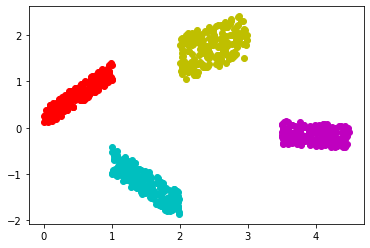

In [24]:
projected_data = som.project_data(data)
clusters = cl[projected_data]

for i in range(data.shape[0]):
    plt.plot(data[i,0], data[i,1],'o', c=cmap[clusters[i]])

In [25]:
def UMat(c1, c2):
    dists = np.zeros(c1.shape)
    for i in range(c1.shape[0]):
        for j in range(c2.shape[1]):
            cnt = 0
            if i > 0:
                dists[i, j] += np.sqrt((c1[i-1, j] - c1[i, j])**2 + (c2[i-1, j] - c2[i, j])**2)
                cnt += 1
            if j > 0:
                dists[i, j] += np.sqrt((c1[i, j-1] - c1[i, j])**2 + (c2[i, j-1] - c2[i, j])**2)
                cnt += 1
            if j < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i, j+1] - c1[i, j])**2 + (c2[i, j+1] - c2[i, j])**2)
                cnt += 1
            if i < c2.shape[1]-1:
                dists[i, j] += np.sqrt((c1[i+1, j] - c1[i, j])**2 + (c2[i+1, j] - c2[i, j])**2)
                cnt += 1
            dists[i, j] /= cnt
    return dists

Here, we are visualizing the U-matrix of the SOM. The UMAT is basically a heatmap in which the distance between adjacent neurons is showed with colors. In this example, the warmer the color, the bigger the distance.

In [26]:
umat = UMat(c1, c2)

<AxesSubplot:>

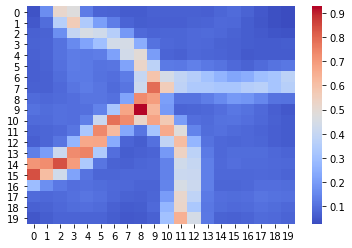

In [27]:
sns.heatmap(umat, cmap='coolwarm')

## Exercise 4

If everything was run correctly, the distance between the neurons in the center should be much larger than any other distance. Why is that?

Once that we have seen how this algorithm works, let's try another toy dataset, this being a little bit more difficult.

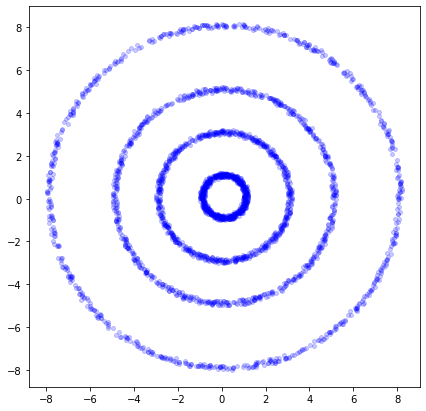

In [28]:
dlen = 700
tetha = np.random.uniform(low=0,high=2*np.pi,size=dlen)[:,np.newaxis]
X1 = 3*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y1 = 3*np.sin(tetha)+ .22*np.random.rand(dlen,1)
Data1 = np.concatenate((X1,Y1),axis=1)

X2 = 1*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y2 = 1*np.sin(tetha)+ .22*np.random.rand(dlen,1)
Data2 = np.concatenate((X2,Y2),axis=1)

X3 = 5*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y3 = 5*np.sin(tetha)+ .22*np.random.rand(dlen,1)
Data3 = np.concatenate((X3,Y3),axis=1)

X4 = 8*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y4 = 8*np.sin(tetha)+ .22*np.random.rand(dlen,1)
Data4 = np.concatenate((X4,Y4),axis=1)



Data2 = np.concatenate((Data1,Data2,Data3,Data4),axis=0)

fig = plt.figure()
plt.plot(Data2[:,0],Data2[:,1],'ob',alpha=0.2, markersize=4)
fig.set_size_inches(7,7)
# plt.plot(np.cos(tetha))

In [29]:
mapsize = [30,30]
som = sompy3.SOMFactory.build(Data2, mapsize, normalization=None)
som.train(n_job=1)

INFO:root: Training...
INFO:root: pca_linear_initialization took: 0.026000 seconds
INFO:root: Rough training...
INFO:root: radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 10

INFO:root: epoch: 1 ---> elapsed time:  0.167000, quantization error: 0.337351

INFO:root: epoch: 2 ---> elapsed time:  0.139000, quantization error: 0.427965

INFO:root: epoch: 3 ---> elapsed time:  0.144000, quantization error: 0.435973

INFO:root: epoch: 4 ---> elapsed time:  0.147000, quantization error: 0.489046

INFO:root: epoch: 5 ---> elapsed time:  0.174000, quantization error: 0.467709

INFO:root: epoch: 6 ---> elapsed time:  0.157000, quantization error: 0.420394

INFO:root: epoch: 7 ---> elapsed time:  0.150000, quantization error: 0.356648

INFO:root: epoch: 8 ---> elapsed time:  0.134000, quantization error: 0.281242

INFO:root: epoch: 9 ---> elapsed time:  0.136000, quantization error: 0.204079

INFO:root: epoch: 10 ---> elapsed time:  0.138000, quantization error: 0.134276

INFO:root: Fine

## Exercise 5

Visualize the values of the two learned new components and observe how they differ from the previous ones

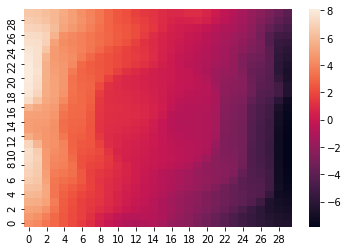

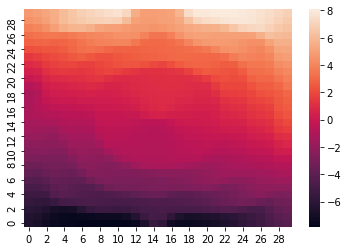

In [30]:
c1, c2 = som.codebook.matrix[:, 0].reshape(mapsize), som.codebook.matrix[:, 1].reshape(mapsize)  # We select the two components (dimensions) in the map, and reshape them
# Two heatmaps, one per component
sns.heatmap(c1, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 30)
plt.show()
sns.heatmap(c2, vmax=np.max(som.codebook.matrix), vmin=np.min(som.codebook.matrix))
plt.ylim(0, 30)
plt.show()

## Exercise 6

Use a clustering method (K-means) to create clusters of the data and make the appropriate visualizations to observe whether the clustering was *correct* or not. Was it correct? Why?

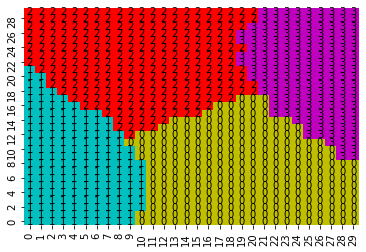

In [31]:
cl = som.cluster(n_clusters=4)
cmap = ["y", "c", "r", "m"]
cluster_space = som.cluster_labels.reshape(mapsize)
sns.heatmap(cluster_space, annot=True, cmap=cmap, annot_kws={"c": "k"}, cbar=False)
plt.ylim(0, 30)
plt.show()

## Exercise 7

Visualize the final layout of the neurons and/or the U-matrix in order to see whether at least that was correctly done

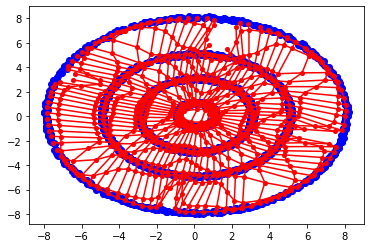

In [32]:
plt.plot(Data2[:,0], Data2[:,1],'o', c="b")
plt.plot(som.codebook.matrix[:, 0], som.codebook.matrix[:, 1], "o", c="r", markersize=4)
for i in range(c1.shape[0]-1):
    for j in range(c2.shape[1]-1):
        plt.plot(c1[i, j:j+2], c2[i, j:j+2], c="r")
        plt.plot(c1[i:i+2, j], c2[i:i+2, j], c="r")

<AxesSubplot:>

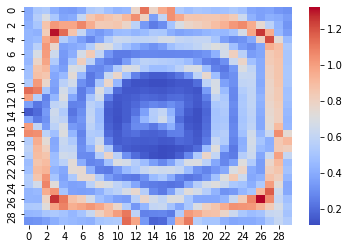

In [33]:
#But Umatrix finds the clusters easily
umat = UMat(c1, c2)
sns.heatmap(umat, cmap='coolwarm')

## Back to tensorflow

Because next week we are going to return to tensorflow, you may want an exercise to get back the touch.

We are going to reuse the first toy database that we created:

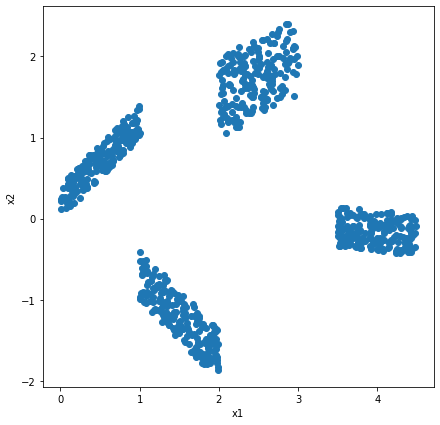

In [34]:
import tensorflow as tf
fig = plt.figure()
plt.plot(data[:,0], data[:,1],'o')
plt.xlabel("x1")
plt.ylabel("x2")
fig.set_size_inches(7,7)

And we are going to transform it into a binary classification problem:

In [35]:
classes = np.array([0]*400+[1]*400).reshape((-1,1))
data_binary = np.concatenate((data,classes), axis=1)

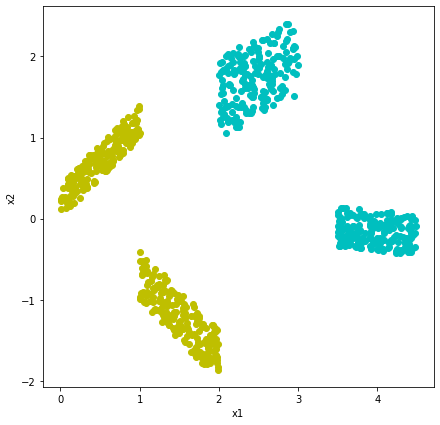

In [36]:
fig = plt.figure()
for i in range(data_binary.shape[0]):
    plt.plot(data_binary[i,0], data_binary[i,1],'o', c=cmap[np.int(data_binary[i,2])])
plt.xlabel("x1")
plt.ylabel("x2")
fig.set_size_inches(7,7)

In this case, we are going to assume that each of the clusters belong to a certain class, and, using linear models, try to predict the class the points belong to.

We have two variables and a class:

In [37]:
tf.reset_default_graph()
# We set the constant operators that will store the values of the 
# feature and response variable

x1 = tf.placeholder("float", name="x1")
x2 = tf.placeholder("float", name="x2")
y = tf.placeholder("float", name="y")

We have one weight for each variable, and a bias value that is added at the end:

In [38]:
w1 = tf.Variable(0.0, name="weight1")
w2 = tf.Variable(0.0, name="weight2")
b = tf.Variable(0.0, name="bias")

The linear model is defined as:

In [39]:
predicted = tf.add(tf.add(tf.multiply(x1, w1), tf.multiply(x2, w2)), b)

And the loss function:

In [40]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=predicted, name="loss")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The optimizer and the rest of variables:

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 20000
train_n_samples = 800
display_step = 4000
perm = np.random.permutation(train_n_samples)

mini_batch_size = 100
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)

Epoch: 4000 Error: 0.31259108
Epoch: 8000 Error: 0.17181824
Epoch: 12000 Error: 0.09846562
Epoch: 16000 Error: 0.05934068
Epoch: 20000 Error: 0.03762232


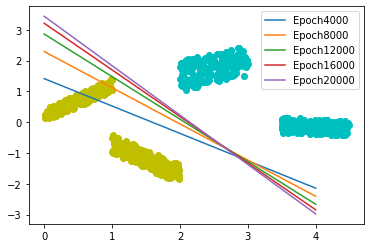

In [54]:
for i in range(data_binary.shape[0]):
    plt.plot(data_binary[i,0], data_binary[i,1],'o', c=cmap[np.int(data_binary[i,2])])
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        i_batch = (epoch % n_batch)*mini_batch_size
        batch = data_binary[i_batch:i_batch+mini_batch_size, 0], data_binary[i_batch:i_batch+mini_batch_size, 1], data_binary[i_batch:i_batch+mini_batch_size, 2]
        sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
        if (epoch+1) % display_step == 0:
            malda, c = -sess.run(w1)/sess.run(w2), -sess.run(b)/sess.run(w2)
            plt.plot([0, 4], [c,c+malda*4], label="Epoch" + str(epoch+1))
            cost = sess.run(loss, feed_dict={x1: data_binary[:, 0], x2: data_binary[:, 1], y: data_binary[:, 2]})
            print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
            linear_params = [sess.run(w1), sess.run(w2), sess.run(b)]
plt.legend()

This problem is easily solved by a linear model, as the classes can be separated by a straight line. However, if we change the problem from being binary to consisting of four classes:

In [43]:
classes = np.array([0]*200+[1]*200+[2]*200+[3]*200).reshape((-1,1))
data_class = np.concatenate((data,classes), axis=1)

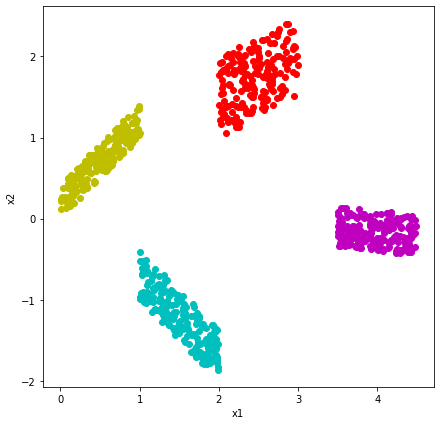

In [44]:
fig = plt.figure()
for i in range(data_class.shape[0]):
    plt.plot(data_class[i,0], data_class[i,1],'o', c=cmap[np.int(data_class[i,2])])
plt.xlabel("x1")
plt.ylabel("x2")
fig.set_size_inches(7,7)

In [45]:
tf.reset_default_graph()
# We set the constant operators that will store the values of the 
# feature and response variable

x1 = tf.placeholder("float", name="x1")
x2 = tf.placeholder("float", name="x2")
y = tf.placeholder("float", name="y")

w1 = tf.Variable(0.0, name="weight1")
w2 = tf.Variable(0.0, name="weight2")
b = tf.Variable(0.0, name="bias")

predicted = tf.add(tf.add(tf.multiply(x1, w1), tf.multiply(x2, w2)), b)

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=predicted, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 20000
train_n_samples = 800
display_step = 4000
perm = np.random.permutation(train_n_samples)

mini_batch_size = 100
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)

Epoch: 4000 Error: -6.909231
Epoch: 8000 Error: -13.696964
Epoch: 12000 Error: -20.467648
Epoch: 16000 Error: -27.236994
Epoch: 20000 Error: -34.006203


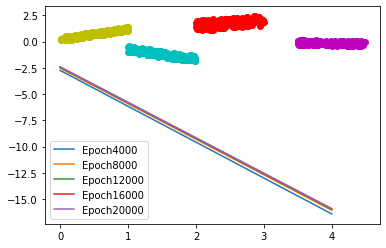

In [46]:
for i in range(data_class.shape[0]):
    plt.plot(data_class[i,0], data_class[i,1],'o', c=cmap[np.int(data_class[i,2])])
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        i_batch = (epoch % n_batch)*mini_batch_size
        batch = data_class[i_batch:i_batch+mini_batch_size, 0], data_class[i_batch:i_batch+mini_batch_size, 1], data_class[i_batch:i_batch+mini_batch_size, 2]
        sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
        if (epoch+1) % display_step == 0:
            malda, c = -sess.run(w1)/sess.run(w2), -sess.run(b)/sess.run(w2)
            plt.plot([0, 4], [c,c+malda*4], label="Epoch" + str(epoch+1))
            cost = sess.run(loss, feed_dict={x1: data_class[:, 0], x2: data_class[:, 1], y: data_class[:, 2]})
            print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
plt.legend()

However, if we were able to combine two linear models into one...

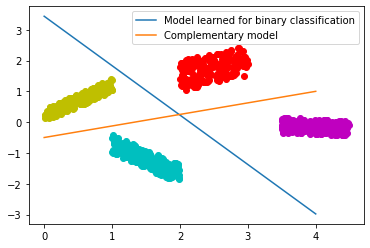

In [47]:
for i in range(data_class.shape[0]):
    plt.plot(data_class[i,0], data_class[i,1],'o', c=cmap[np.int(data_class[i,2])])
    
    
plt.plot([0, 4], [-linear_params[2]/linear_params[1],-linear_params[2]/linear_params[1]-linear_params[0]/linear_params[1]*4], label="Model learned for binary classification")
plt.plot([0, 4], [-0.5,1], label="Complementary model")
plt.legend()

## Exercise 8

Learn a second binary model that is able to complement the first one so that you can easily program a function that takes a decision about the class of an example taking into account the predictions made by the two models

In [48]:
# Define the new dataset with the corresponding classes so that the model is complementary to the second one

classes_complement = np.array([0]*200+[1]*200+[0]*200+[1]*200).reshape((-1,1))
data_binary_complement = np.concatenate((data,classes_complement), axis=1)

In [49]:
# Define the second tf model

tf.reset_default_graph()
# We set the constant operators that will store the values of the 
# feature and response variable

x1 = tf.placeholder("float", name="x1")
x2 = tf.placeholder("float", name="x2")
y = tf.placeholder("float", name="y")

w1 = tf.Variable(0.0, name="weight1")
w2 = tf.Variable(0.0, name="weight2")
b = tf.Variable(0.0, name="bias")

predicted = tf.add(tf.add(tf.multiply(x1, w1), tf.multiply(x2, w2)), b)

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=predicted, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

init = tf.global_variables_initializer()

# Number of iterations for the learning algorithm
training_epochs = 20000
train_n_samples = 800
display_step = 4000
perm = np.random.permutation(train_n_samples)

mini_batch_size = 100
n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)

Epoch: 4000 Error: 0.09397232
Epoch: 8000 Error: 0.02252951
Epoch: 12000 Error: 0.0059519396
Epoch: 16000 Error: 0.0016633265
Epoch: 20000 Error: 0.00048984465


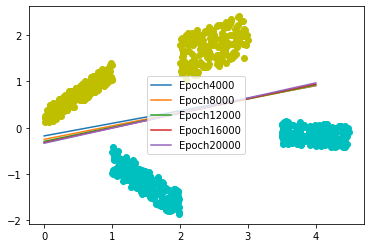

In [50]:
for i in range(data_binary_complement.shape[0]):
    plt.plot(data_binary_complement[i,0], data_binary_complement[i,1],'o', c=cmap[np.int(data_binary_complement[i,2])])
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        i_batch = (epoch % n_batch)*mini_batch_size
        batch = data_binary_complement[i_batch:i_batch+mini_batch_size, 0], data_binary_complement[i_batch:i_batch+mini_batch_size, 1], data_binary_complement[i_batch:i_batch+mini_batch_size, 2]
        sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
        if (epoch+1) % display_step == 0:
            malda, c = -sess.run(w1)/sess.run(w2), -sess.run(b)/sess.run(w2)
            plt.plot([0, 4], [c,c+malda*4], label="Epoch" + str(epoch+1))
            cost = sess.run(loss, feed_dict={x1: data_binary_complement[:, 0], x2: data_binary_complement[:, 1], y: data_binary_complement[:, 2]})
            print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
            linear_params_complement = [sess.run(w1), sess.run(w2), c]
plt.legend()

In [51]:
# Define the decision function, if you want, you can follow this pattern:

def four_class_decision(example, model1_params, model2_params):
    prediction1 = model1_params[0]*example[0] + model1_params[1]*example[1] + model1_params[2]
    prediction2 = model2_params[0]*example[0] + model2_params[1]*example[1] + model2_params[2]
    
    if prediction1<0:
        if prediction2<0:
            return 0
        else:
            return 2
    else:
        if prediction2<0:
            return 1
        else:
            return 3

In [52]:
a = [four_class_decision(example, linear_params_complement, linear_params) for example in data_class[:, :2]]

In [53]:
(a == data_class[:, 2]).all()

True